# Data processing

In [5]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import random
import re 
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
th.set_num_threads(2)
#th.set_num_interop_threads(2)

n_model=3


In [6]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", r" \( ", string)
    string = re.sub(r"\)", r" \) ", string)
    string = re.sub(r"\?", r" \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    dataset=[]
    with open(filename, encoding="utf-8") as f:
        line = f.readline()
        cpt=1
        skip=0
        while line :
            cleanline = clean_str(f.readline()).split()

            
            if cleanline: 
                dataset.append(cleanline)
            else: 
                line = f.readline()
                skip+=1
                continue
            if limit > 0 and cpt >= limit: 
                break
            line = f.readline()
            cpt+=1        

        print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
        
    for i in range(len(dataset)):
        # remove the last two tokens BUT ONLY if they are actually label + ID
        if dataset[i][-2].isdigit() and dataset[i][-1].isalnum():
            dataset[i] = dataset[i][:-2]

        dataset[i] = [w for w in dataset[i] if w != ","] #remove single commas
    

    return dataset


In [7]:
train_data_text = loadTexts("train.tsv")
test_data_text = loadTexts("test.tsv")
dev_data_text = loadTexts("dev.tsv")

for i in range(len(dev_data_text)):
    dev_data_text[i] = dev_data_text[i][:-2] # remove the "," and other index at the end of each sentence


Load  21706  lines from  train.tsv  /  0  lines discarded
Load  2714  lines from  test.tsv  /  1  lines discarded
Load  2714  lines from  dev.tsv  /  0  lines discarded


In [8]:
print(dev_data_text[0:20])

[['you', 'know', 'the', 'answer', 'man', 'you', 'are', 'programmed', 'to', 'capture', 'those', 'codes', 'they', 'send', 'you', 'don', 't', 'avoid', 'them'], ['the', 'economy', 'is', 'heavily', 'controlled', 'and', 'subsidized', 'by', 'the', 'government', 'in', 'any', 'case', 'i', 'was', 'poking', 'at', 'the', 'lack', 'of', 'nuance', 'in', 'us', 'politics'], ['thank', 'you', 'for', 'your', 'vote', 'of', 'confidence', 'but', 'we', 'statistically', 'ca', "n't", 'get', 'to'], ['there', 'it'], ['good', 'we', 'do', "n't", 'want', 'more', 'thrash', 'liberal', 'offspring', 'in'], ['i', 'went', 'to', 'a', 'destination', 'wedding', 'being', 'the', 'only', 'single', 'person', 'promised', 'to', 'never', 'put', 'myself', 'in', 'that', 'situation'], ['like', 'this', 'just', 'cuz', 'of', 'the', 'name', 'rhymes', 'background', 'raps', 'but', 'dude', 'your', 'name', 'is', 'sick'], ['as', 'an', 'anesthesia', 'resident', 'this', 'made', 'me', 'blow', 'air', 'out', 'my', 'nose', 'at', 'an', 'accelerated',

### Word dictionnary

In first implementation the vocabulary size is 18 657 which is quite huge as it include every single word, even very rare ones.
The computing time is very high so we decide to add a freqency min as a threshold. For at least 2 occurences to appear in dictionnary the vocab size goes down to 8 964.

In [9]:
class WordDict:
    # constructor, words must be a set containing all words
    def __init__(self, words):
        assert type(words) == set
        # TODO
        self.words=sorted(list(words))
        self.word_dict_={w: i for i, w in enumerate(self.words)}
        self.id_dict_={i: w for i, w in enumerate(self.words)}
        
    # return the integer associated with a word
    def word_to_id(self, word):
        assert type(word) == str
        return self.word_dict_[word]


    # return the word associated with an integer
    def id_to_word(self, idx):
        assert type(idx) == int
        # TODO
        return self.id_dict_[idx]
    
     # number of word in the dictionnary
    def __len__(self):
        # TODO
        return len(self.word_dict_)

# Count frequency of each word
counter = Counter()
for sentence in train_data_text:
    counter.update(sentence)
    
    
train_words = set()
train_words.update(["<bos>", "<eos>","<unk>","<pad>"])
frequency_min=2

for word, freq in counter.items():
    if freq >= frequency_min:
        train_words.add(word)

word_dict = WordDict(train_words)

vocab_size=len(word_dict)
print(vocab_size)

8965


### Processing the data

We first tensorize the data into indexes from the word dictionnary then generate training pair

In [10]:
def tensorize_sentence(sentence,n=n_model):
    """
    Tensorizing function
    Args: sentence: list of words as text
    Returns: output_tensor: Tensors of type long, encoding the words via index of the word dictionnary
    """
    start_index=word_dict.word_dict_["<bos>"]
    end_index=word_dict.word_dict_["<eos>"]
    output_tensor=[word_dict.word_dict_.get(word, word_dict.word_dict_["<unk>"]) for word in sentence]
    output_tensor=[start_index]*(n-1)+output_tensor+[end_index] # pad accoring to n to ensure correct first n-gram
    return output_tensor

train_data = [tensorize_sentence(sentence) for sentence in train_data_text]
test_data = [tensorize_sentence(sentence) for sentence in test_data_text]
dev_data = [tensorize_sentence(sentence) for sentence in dev_data_text]


In [11]:
def generate_pairs(training_data,n=n_model):
    """
    Generate context,target pairs to train the MLP on
    Args: 
        traning_data: list of words as indexes, 
        n size of the Ngram  model
    
    Returns:         
        X: list of context vectors of shape (n-1,)
        y: list of target word IDs
    """
    X=[]
    y=[]
    for sentence in training_data:
        for index,word in enumerate(sentence) :
            if index>= n-1:
                training_words=sentence[index-(n-1):index]
                target_word=word
                X.append(training_words)
                y.append(target_word)

    return X,y

def proces_data(data_set,n=n_model):
    tensorized_data = [tensorize_sentence(sentence,n) for sentence in data_set]
    X,y=generate_pairs(tensorized_data,n)
    X=th.tensor(X, dtype=th.long)
    y=th.tensor(y, dtype=th.long)
    return X,y


X_train,y_train=proces_data(train_data_text)
X_test,y_test=proces_data(test_data_text)
X_dev,y_dev=proces_data(dev_data_text)

print(f"Training dataset shape: {X_train.shape}")
print(f"Test dataset shape: {X_test.shape}")
print(f"Dev dataset shape: {X_dev.shape}")


Training dataset shape: torch.Size([322543, 2])
Test dataset shape: torch.Size([39531, 2])
Dev dataset shape: torch.Size([34792, 2])


# Perpexity Class


Perplexity correponds to how surprised the model is by the test text, it is inversly correlated with the likelihood of the text given the model.


In [17]:
class Perplexity:

    
    def __init__(self):
        self.total_log_prob=0.0
        self.count = 0


    def reset(self):
        self.total_log_prob=0.0
        self.count = 0


    def add_sentence(self, log_probs):
        """
        log_probs: 1D tensor or list of log probabilities of 
                   all words in a sentence.
                   We just add the to the total log probability
        """
        self.total_log_prob += log_probs.sum().item()
        self.count += len(log_probs)


    def compute_perplexity(self):
        return math.exp(- self.total_log_prob / self.count)
    

# Neural N Gram model

In [ ]:
class NeuralNgram(nn.Module):

    def __init__(self,n=n_model,embedding_dim=100,hidden_dim=64):
        super().__init__()
        self.n=n
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dim=embedding_dim
        
        # Small MLP classifier 
        self.mlp = nn.Sequential(
            nn.Linear((self.n-1)*embedding_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, vocab_size)
        )

        #Logging objects
        self.loss_history=[]
        self.dev_perplexity_history=[]
        self.train_perplexity_history=[]
        self.X_dev=X_dev
        self.y_dev=y_dev


    def forward(self,inputs):
        """
        Forward pass for Neural Ngram.

        Args:
            inputs: LongTensor of shape (batch_size, n-1)
                    where each entry is a token index.

        Returns:
            logits: Tensor of shape (batch_size,vocab_size)
        """
        # Convert tokens to embeddings Shape (batch_size,n,embedding size) → (batch, seq_len, embedding_dim)
        embeds = self.emb(inputs)
        embeds = embeds.view(inputs.size(0), self.embedding_dim * (self.n-1))         # flatten (batch_size, 2*emb_dim) to correct mlp size
        logits=self.mlp(embeds)
        return logits
    

    def fit(self,X_train,y_train,epochs=3,lr=0.001,batch_size=64):
        self.train()
        optimizer = th.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(1,epochs+1):
            
            #Shuffle data to maximise randomness
            perm = th.randperm(len(X_train))
            X_train = X_train[perm]
            y_train = y_train[perm]

            total_loss=0.0

            for start in range(0, len(X_train), batch_size):
                optimizer.zero_grad()
                xb = X_train[start:start + batch_size]
                yb = y_train[start:start + batch_size]

                logits=self.forward(xb)
                loss=criterion(logits,yb)
                
                loss.backward()
                optimizer.step()
                total_loss+= loss.item()*xb.size(0)


            avg_loss = total_loss/len(X_train)
            self.loss_history.append(avg_loss)
            print(f"Loss at epoch {epoch}: {avg_loss}")
            self.dev_perplexity_history.append(self.get_perplexity(self.X_dev,self.y_dev))
            self.train_perplexity_history.append(self.get_perplexity(X_train,y_train))


    def get_perplexity(self,X_test,y_test):
        """
        Get perplexity for the model on the test set by getting the log-probs of correct words 
        """
        ppx=Perplexity()
        logits=self.forward(X_test)
        log_probs=th.log_softmax(logits, dim=1)
        correct_lp=log_probs[range(len(y_test)), y_test]  
        ppx.add_sentence(correct_lp)
        
        return ppx.compute_perplexity()

### Test for optimizing parameters

We observe signs of overfitting beyond epoch 4. Aside from this, the base optimization settings—learning rate and batch size—appear well-chosen.

In [42]:
nngram=NeuralNgram()
nngram.fit(X_train=X_train,y_train=y_train,epochs=10)

100%|██████████| 5040/5040 [00:42<00:00, 119.17it/s]


Loss at epoch 1: 5.963088785197239


100%|██████████| 5040/5040 [00:55<00:00, 91.52it/s] 


Loss at epoch 2: 5.42056735477185


100%|██████████| 5040/5040 [00:41<00:00, 120.01it/s]


Loss at epoch 3: 5.2642396864472065


100%|██████████| 5040/5040 [00:43<00:00, 115.36it/s]


Loss at epoch 4: 5.159184018684246


100%|██████████| 5040/5040 [00:43<00:00, 116.76it/s]


Loss at epoch 5: 5.077179370571893


100%|██████████| 5040/5040 [00:42<00:00, 118.66it/s]


Loss at epoch 6: 5.008492318067154


100%|██████████| 5040/5040 [00:42<00:00, 119.64it/s]


Loss at epoch 7: 4.948889071450639


100%|██████████| 5040/5040 [00:39<00:00, 126.55it/s]


Loss at epoch 8: 4.896441788293949


100%|██████████| 5040/5040 [00:40<00:00, 124.85it/s]


Loss at epoch 9: 4.8480548863122035


100%|██████████| 5040/5040 [00:42<00:00, 119.53it/s]


Loss at epoch 10: 4.804802566271948


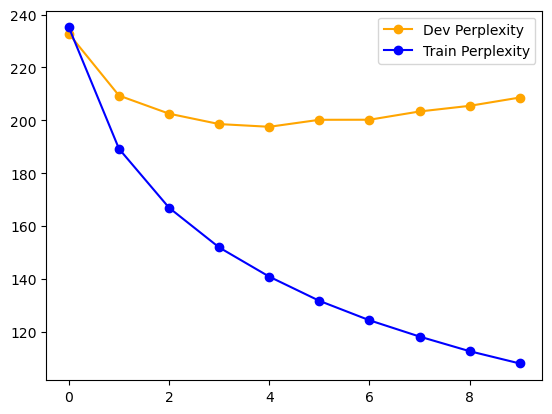

In [43]:
plt.plot(nngram.dev_perplexity_history, label="Dev Perplexity", marker="o",color='orange')
plt.plot(nngram.train_perplexity_history, label="Train Perplexity", marker="o",color='blue')
plt.legend()
plt.show()

## Hyperparameters Tuning

  0%|          | 0/5 [00:00<?, ?it/s]

Loss at epoch 1: 5.964044460589312
Loss at epoch 2: 5.449851622961585
Loss at epoch 3: 5.3160805837554035
Loss at epoch 1: 5.964108330583662
Loss at epoch 2: 5.420997479025788
Loss at epoch 3: 5.262676883450421
Loss at epoch 1: 5.9651335816297575
Loss at epoch 2: 5.439924280343125
Loss at epoch 3: 5.278082555648637
Loss at epoch 1: 5.985821844995607
Loss at epoch 2: 5.479438330796212
Loss at epoch 3: 5.321316032501208
Loss at epoch 1: 5.987850454147263
Loss at epoch 2: 5.481704427039995
Loss at epoch 3: 5.32438920537927


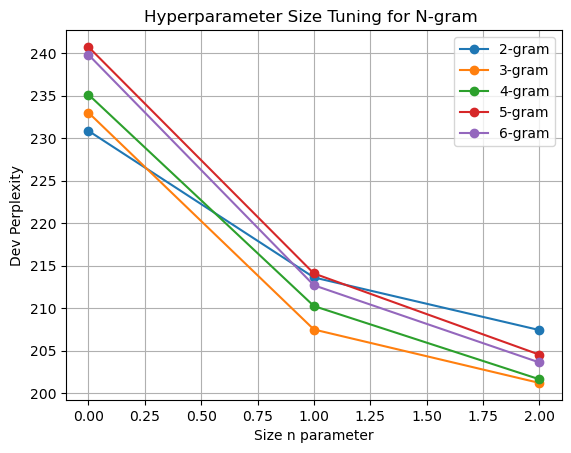

In [12]:
# Size tuning

n_grid=[2,3,4,5,6]

global_perplexity={}

for n in tqdm(n_grid):
    X_train,y_train=proces_data(train_data_text,n=n)
    X_dev,y_dev=proces_data(dev_data_text,n=n)
    global_perplexity[n]=[]


    nngram=NeuralNgram(embedding_dim=100,n=n)
    nngram.fit(X_train,y_train)

    global_perplexity[n]=nngram.dev_perplexity_history.copy()
        
    plt.plot(global_perplexity[n], label=F"{n}-gram", marker="o")

plt.xlabel("Size n parameter")
plt.ylabel("Dev Perplexity")
plt.title("Hyperparameter Size Tuning for N-gram ")
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

Loss at epoch 1: 6.0219449029445276
Loss at epoch 2: 5.500274017026176
Loss at epoch 3: 5.362711138249586
Loss at epoch 1: 5.970113338757995
Loss at epoch 2: 5.458474106035747
Loss at epoch 3: 5.320565667113982
Loss at epoch 1: 5.926005658261227
Loss at epoch 2: 5.422950961285173
Loss at epoch 3: 5.291225538294499


  0%|          | 0/3 [00:00<?, ?it/s]

Loss at epoch 1: 6.017715063091042
Loss at epoch 2: 5.46414323861823
Loss at epoch 3: 5.310617009886525
Loss at epoch 1: 5.954568566568838
Loss at epoch 2: 5.413187293370531
Loss at epoch 3: 5.256674543957484
Loss at epoch 1: 5.909923984619436
Loss at epoch 2: 5.393469976722376
Loss at epoch 3: 5.233992209130128


  0%|          | 0/3 [00:00<?, ?it/s]

Loss at epoch 1: 6.016312687487989
Loss at epoch 2: 5.474175164083836
Loss at epoch 3: 5.316281031575889
Loss at epoch 1: 5.966329208756956
Loss at epoch 2: 5.437762907147491
Loss at epoch 3: 5.2758812757112485
Loss at epoch 1: 5.924387067383689
Loss at epoch 2: 5.412476127615866
Loss at epoch 3: 5.253925364011344


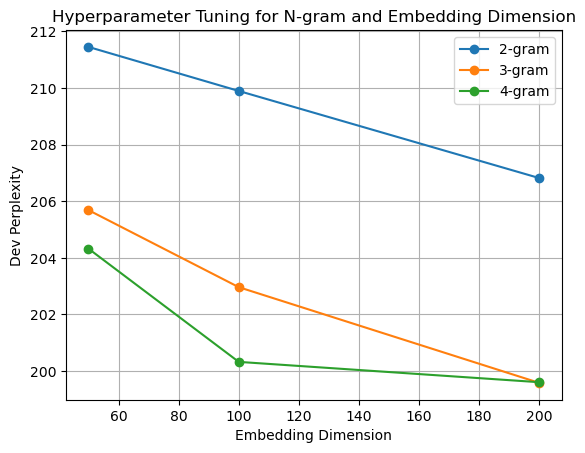

In [ ]:
# Embedding dimension tuning

n_grid=[2,3,4]
embedding_dimension=[50,100,200]
global_perplexity={}

for n in n_grid:
    X_train,y_train=proces_data(train_data_text,n=n)
    X_dev,y_dev=proces_data(dev_data_text,n=n)
    global_perplexity[n]=[]

    for dim in tqdm(embedding_dimension):
        nngram=NeuralNgram(embedding_dim=dim,n=n)
        nngram.fit(X_train,y_train)

        global_perplexity[n].append(nngram.get_perplexity(X_dev,y_dev))
        
    plt.plot(embedding_dimension,global_perplexity[n], label=F"{n}-gram", marker="o")

plt.xlabel("Embedding Dimension")
plt.ylabel("Dev Perplexity")
plt.title("Hyperparameter Tuning for N-gram and Embedding Dimension")
plt.legend()
plt.grid(True)
plt.show()


Loss at epoch 1: 5.975709668100755
Loss at epoch 2: 5.455901325793275
Loss at epoch 3: 5.319746419718432
Loss at epoch 1: 5.867928226547988
Loss at epoch 2: 5.368686871768668
Loss at epoch 3: 5.214315827703449
Loss at epoch 1: 5.815993428252831
Loss at epoch 2: 5.312553645971341
Loss at epoch 3: 5.133220105857418
Loss at epoch 1: 5.966364073229941
Loss at epoch 2: 5.421352324644836
Loss at epoch 3: 5.264747618721189
Loss at epoch 1: 5.853130223689028
Loss at epoch 2: 5.314890207797724
Loss at epoch 3: 5.125310339429921
Loss at epoch 1: 5.800016365689096
Loss at epoch 2: 5.22161370970366
Loss at epoch 3: 4.96529967861838
Loss at epoch 1: 5.972604949481217
Loss at epoch 2: 5.44304751788813
Loss at epoch 3: 5.283457022965759
Loss at epoch 1: 5.84871691044542
Loss at epoch 2: 5.31805594929419
Loss at epoch 3: 5.121270785678241
Loss at epoch 1: 5.803037969847338
Loss at epoch 2: 5.211749222347169
Loss at epoch 3: 4.935056151977351


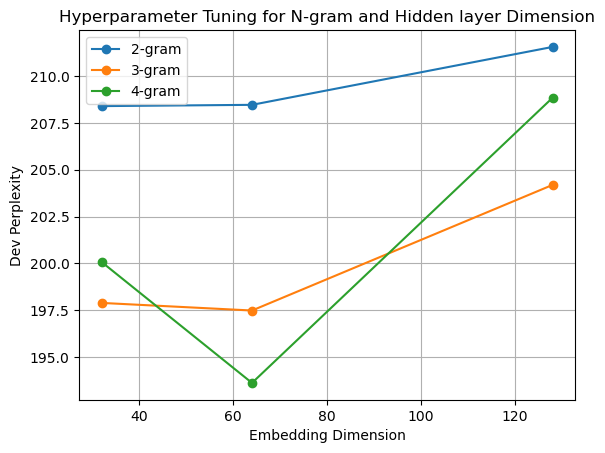

In [13]:
# Hidden dimension tuning

n_grid=[2,3,4]
hidden_dimension=[32,64,128]
global_perplexity={}

for n in n_grid:
    X_train,y_train=proces_data(train_data_text,n=n)
    X_dev,y_dev=proces_data(dev_data_text,n=n)
    global_perplexity[n]=[]

    for dim in hidden_dimension:
        nngram=NeuralNgram(embedding_dim=100,n=n,hidden_dim=dim)
        nngram.fit(X_train,y_train)

        global_perplexity[n].append(nngram.get_perplexity(X_dev,y_dev))
        
    plt.plot(hidden_dimension,global_perplexity[n], label=F"{n}-gram", marker="o")

plt.xlabel("Embedding Dimension")
plt.ylabel("Dev Perplexity")
plt.title("Hyperparameter Tuning for N-gram and Hidden layer Dimension")
plt.legend()
plt.grid(True)
plt.show()

# LSTM model

## Data processing

For the LSTM model, the data processing is not the same, the model expect padded sequence of same lenght.

In [12]:
train_data = [tensorize_sentence(sentence) for sentence in train_data_text]
test_data = [tensorize_sentence(sentence) for sentence in test_data_text]
dev_data = [tensorize_sentence(sentence) for sentence in dev_data_text]

In [13]:
class VariationalDropout(nn.Module):
    '''
    Variational dropout samples a single dropout mask per batch and reuses it across all timesteps.
    '''
    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training or self.p == 0:
            return x
        
        # one mask for entire batch & all timesteps
        mask = x.new_empty((1, 1, x.size(2))).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)

        return x * mask

## LSTM Class

In [14]:
class myLSTM(nn.Module):
    def __init__(self,embedding_dim=100,hidden_dim=128,variational_dropout=0.3,word_dropout=0.1,dev_data=dev_data):
        super().__init__()
        self.word_dropout = word_dropout
        self.unk_id = word_dict.word_to_id("<unk>")
        self.pad_id=word_dict.word_to_id("<pad>")
        self.vocab_size=vocab_size
        self.emb=nn.Embedding(vocab_size,embedding_dim)

        # LSTM model
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
        )

        #Variationnal dropout
        self.vdrop=VariationalDropout(variational_dropout)

        #Decoder
        self.decoder = nn.Linear(hidden_dim, vocab_size)

        # Logging
        self.dev_perplexity_history=[]
        self.loss_history=[]
        self.dev_data=dev_data


    def apply_word_dropout(self, x):
        '''
        Droupout at word level: replace some words with <unk> to force the model no to rely on specific words 
        '''
        if not self.training or self.word_dropout == 0:
            return x
        mask = th.rand_like(x, dtype=th.float) < self.word_dropout
        x = x.clone()
        x[mask] = self.unk_id
        return x

    def forward(self,data):
        '''
        Input: data of shape (batch_size,sentence_lenght) 

            -Apply word level dropout
            -Get embedding
            -Apply LSTM model 
            Variational dropout on LSTM outputs (one mask per forward) 
            Decode into probabilities 

        Output: logits
        '''

        data = self.apply_word_dropout(data)

        embedding= self.emb(data)
        out, _ = self.lstm(embedding)
        
        out=self.vdrop(out)
        logits = self.decoder(out)

        return logits
    
    def fit(self,train_data,epochs=3,batch_size=32,lr=0.001):
        
        self.train()
        optimizer = th.optim.Adam(self.parameters(), lr=lr)
        criterion=nn.CrossEntropyLoss(ignore_index=self.pad_id)
        
        for epoch in range(1,epochs+1):
            total_loss=0
            n_batches=0
            random.shuffle(train_data)

            for start in range(0, len(train_data), batch_size):
                optimizer.zero_grad()
                batch_data = train_data[start:start + batch_size]
                batch_tensor=[th.tensor(seq, dtype=th.long) for seq in batch_data]

                padded = pad_sequence(batch_tensor,batch_first=True,padding_value=self.pad_id) # padding
               
                input_data= padded[:,:-1] # input is all tokens except last in teacher forcing
                target_data=padded[:,1:] # target is all tokens except first

                optimizer.zero_grad()
                logits=self.forward(input_data)
                
                loss = criterion(logits.reshape(-1, self.vocab_size),target_data.reshape(-1))
                
                loss.backward()
                optimizer.step()
                total_loss+= loss.item()
                n_batches+=1


            avg_loss = total_loss/n_batches
            self.loss_history.append(avg_loss)
            self.dev_perplexity_history.append(self.get_perplexity(self.dev_data))
            print(f"Loss at epoch {epoch}: {avg_loss:.4f}")


    def get_perplexity(self,test_data):
        self.eval() # no dropout
        meter = Perplexity() 
        with th.no_grad():
            for sentence in test_data:
                tensor=th.tensor(sentence, dtype=th.long).unsqueeze(0)
                inputs  =tensor[:,:-1]   # all except last
                targets =tensor[:,1:]    # all except first


                logits=self.forward(inputs)
                log_probs=th.log_softmax(logits, dim=-1) 
                t=targets[0]
                lp=log_probs[0, th.arange(len(t)), t]
            
                lp=lp[(t !=self.pad_id)] # remove padded indexes

                meter.add_sentence(lp)

        return meter.compute_perplexity()


In [ ]:
lstm=myLSTM(embedding_dim=100,hidden_dim=128,variational_dropout=0.3,word_dropout=0.1)

lstm.fit(train_data)
print(lstm.dev_perplexity_history)